# Exercise Sheet 7
This Notebook contains Exercise 20-22

# Exercise 20
This Exercise lays the base for the next ones!

We consider the advection diffusion problem
on the one-dimensional domain $\Omega=(0,1)\subset\mathbb{R}$.
\begin{aligned}
- \Delta u + \beta\cdot\nabla u &= f && \text{ in } \Omega, \\
u &= g && \text{on } \partial\Omega .
\end{aligned}
With $\beta=1$, $f(x)=\sin(11\pi x)$, and homogeneous Dirichlet data $g=0$, the problem becomes
# Exercise 1(a): Exact solution in 1D

## Step 1: Homogeneous solution
Solve $u''-u'=0$. The characteristic polynomial is $r^2-r=0$, hence $r\in\{0,1\}$, and
$u_h(x)=C_1 + C_2 e^x.$

## Step 2: Particular solution
Use the ansatz $u_p(x)=A\sin(kx)+B\cos(kx)$. Then
$u_p'(x)=Ak\cos(kx)-Bk\sin(kx),\qquad
u_p''(x)=-Ak^2\sin(kx)-Bk^2\cos(kx),$
so
$u_p''-u_p'
=
\bigl(-(k^2A)+kB\bigr)\sin(kx)
+
\bigl(-(k^2B)-kA\bigr)\cos(kx).$
Matching $u_p''-u_p'=-\sin(kx)$ yields the linear system
$-(k^2A)+kB=-1,\qquad -(k^2B)-kA=0.$
Solving gives
$A=\frac{1}{k^2+1},\qquad B=-\frac{1}{k(k^2+1)}.$
Thus
$u_p(x)=\frac{1}{k^2+1}\sin(kx)-\frac{1}{k(k^2+1)}\cos(kx).$

## Step 3: Impose boundary conditions
The general solution is $u=u_h+u_p$:
$u(x)=C_1+C_2e^x+\frac{1}{k^2+1}\sin(kx)-\frac{1}{k(k^2+1)}\cos(kx).$

From $u(0)=0$ we obtain
$C_1+C_2-\frac{1}{k(k^2+1)}=0
\quad\Rightarrow\quad
C_1=\frac{1}{k(k^2+1)}-C_2.$

From $u(1)=0$ and $\sin(k)=\sin(11\pi)=0$, $\cos(k)=\cos(11\pi)=-1$,
$0=C_1+C_2e+\frac{1}{k(k^2+1)}.$
Substituting $C_1$ gives
$0=\left(\frac{1}{k(k^2+1)}-C_2\right)+C_2e+\frac{1}{k(k^2+1)}
=\frac{2}{k(k^2+1)}+C_2(e-1),$
hence
$C_2=-\frac{2}{k(k^2+1)(e-1)},\qquad
C_1=\frac{e+1}{k(k^2+1)(e-1)}.$

## Final closed-form solution
With $k=11\pi$,
$\boxed{
u(x)=\frac{e+1-2e^x}{k(k^2+1)(e-1)}
+\frac{1}{k^2+1}\sin(kx)
-\frac{1}{k(k^2+1)}\cos(kx),
\qquad k=11\pi.
}$
This satisfies $-u''+u'=\sin(11\pi x)$ on $(0,1)$ and $u(0)=u(1)=0$.




In [5]:
# run imports
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from ngsolve import *
from ngsolve.webgui import Draw
import ngsolve as ng

from netgen.occ import * 
from ngsolve import x, y, sqrt, atan2, sin

from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Callable, Dict, Iterable, List, Mapping, Optional, Sequence, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt

## Helpers
This is the framework for reusing the shared code between all experiments
calculating convergence for different parameters based on a specific solver-mesh-domain
plotting and drawing my results
this saves me from copying and adopting the same parts on different places and possibly introducing errrors.


from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Mapping, Optional, Sequence, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt

import ngsolve as ng
from ngsolve import (
    Mesh, H1, GridFunction, BilinearForm, LinearForm, TaskManager,
    CF, x, dx, grad, InnerProduct, Integrate, sin, cos, exp
)
import ngsolve.webgui as webgui

Number = Union[int, float]
Params = Dict[str, Any]

SolveFn = Callable[..., Tuple[Any, Any, Dict[str, Any]]]   # (gfu, mesh, extra)
ErrorFn = Callable[[Any, Any, Dict[str, Any]], float]      # (gfu, mesh, extra) -> float

## Core utilities (rates + annotations)

In [6]:
def compute_rates(errors: Sequence[float], hs: Sequence[float]) -> List[float]:
    """Local rates p_i = log(E_i/E_{i+1}) / log(h_i/h_{i+1})"""
    rates: List[float] = []
    for i in range(len(errors) - 1):
        Ei, Ej = float(errors[i]), float(errors[i + 1])
        hi, hj = float(hs[i]), float(hs[i + 1])
        if Ej == 0 or hi == hj:
            rates.append(float("nan"))
        else:
            rates.append(float(np.log(Ei / Ej) / np.log(hi / hj)))
    return rates


def _annotate_rates(ax, hs, errs, rates, y_offset=0.05):
    for i, r in enumerate(rates):
        x_mid = np.sqrt(hs[i] * hs[i + 1])
        y_mid = np.sqrt(errs[i] * errs[i + 1])
        ax.text(x_mid, y_mid * (1 + y_offset), f"{r:.2f}", fontsize=9, ha="center")


def _params_key(params: Mapping[str, Any]) -> Tuple[Tuple[str, Any], ...]:
    return tuple(sorted(params.items(), key=lambda kv: kv[0]))


def _h_key(h: float, ndigits: int = 12) -> float:
    return round(float(h), ndigits)

## Data structures

In [ ]:
@dataclass(frozen=True)
class RunSpec:
    h: float
    order: int
    params: Tuple[Tuple[str, Any], ...]


@dataclass
class SolutionStore:
    gfu: Any
    mesh: Any
    extra: Dict[str, Any]


@dataclass
class RunResult:
    spec: RunSpec
    errors: Dict[str, float]
    solution: Optional[SolutionStore] = None


class StudyGroup:
    """One fixed (order, params) slice. Index by h: grp[h] -> RunResult"""

    def __init__(self, *, order: int, params: Params, results: List[RunResult], h_ndigits: int = 12):
        self.order = int(order)
        self.params = dict(params)
        self._pkey = _params_key(self.params)
        self._h_ndigits = h_ndigits

        self._by_h: Dict[float, RunResult] = {}
        for r in results:
            if r.spec.order != self.order or r.spec.params != self._pkey:
                continue
            self._by_h[_h_key(r.spec.h, self._h_ndigits)] = r

        if not self._by_h:
            raise KeyError(f"No results for order={self.order}, params={self.params}")

    def hs(self) -> List[float]:
        return sorted(self._by_h.keys(), reverse=True)  # coarse -> fine

    def __getitem__(self, h: float) -> RunResult:
        hk = _h_key(h, self._h_ndigits)
        if hk not in self._by_h:
            raise KeyError(f"h={h} not found. Available: {self.hs()}")
        return self._by_h[hk]

    def error_names(self) -> List[str]:
        rr0 = self._by_h[self.hs()[0]]
        return list(rr0.errors.keys())

    def hs_eff(self):
        return [self._by_h[h].solution.extra.get("h_eff", h) for h in self.hs()]



class ConvergenceStudy:
    def __init__(self, *, h_ndigits: int = 12):
        self._results: List[RunResult] = []
        self._h_ndigits = h_ndigits

    @property
    def results(self) -> List[RunResult]:
        return list(self._results)

    def add(self, rr: RunResult) -> None:
        self._results.append(rr)

    def orders(self) -> List[int]:
        return sorted(set(r.spec.order for r in self._results))

    def params_keys(self) -> List[Tuple[Tuple[str, Any], ...]]:
        return sorted(set(r.spec.params for r in self._results))

    def group(self, *, order: int, params: Optional[Params] = None) -> StudyGroup:
        return StudyGroup(order=order, params=params or {}, results=self._results, h_ndigits=self._h_ndigits)

## Runner: run_study (generic, any error dict)

In [ ]:
def run_study(
    *,
    solve_fn: SolveFn,
    hs: Sequence[Number],
    orders: Union[int, Sequence[int]] = 1,
    params_list: Optional[Sequence[Params]] = None,
    errors: Dict[str, ErrorFn],
    store_solution: bool = False,
) -> ConvergenceStudy:
    hs_list = [float(v) for v in hs]
    orders_list = [int(orders)] if isinstance(orders, int) else [int(v) for v in orders]
    params_list = list(params_list) if params_list is not None else [dict()]

    study = ConvergenceStudy()

    for p in params_list:
        pkey = _params_key(p)
        for order in orders_list:
            for h in hs_list:
                gfu, mesh, extra = solve_fn(h=h, order=order, **p)

                err_vals: Dict[str, float] = {}
                for name, fn in errors.items():
                    err_vals[name] = float(fn(gfu, mesh, extra))

                sol = SolutionStore(gfu=gfu, mesh=mesh, extra=dict(extra)) if store_solution else None

                study.add(
                    RunResult(
                        spec=RunSpec(h=float(h), order=int(order), params=pkey),
                        errors=err_vals,
                        solution=sol,
                    )
                )

    return study

## Presentation helpers: table / plot / compare / draw

In [ ]:
def table_group(grp: StudyGroup, *, which: Optional[Sequence[str]] = None) -> str:
    hs = grp.hs()
    names = grp.error_names()
    if which is not None:
        wanted = set(which)
        names = [n for n in names if n in wanted]

    cols = []
    for name in names:
        vals = [grp[h].errors[name] for h in hs]
        cols.append((name, vals, compute_rates(vals, hs)))

    header = f"order={grp.order}"
    if grp.params:
        header += " | " + ", ".join(f"{k}={v}" for k, v in sorted(grp.params.items()))

    lines = [header]
    lines.append("h\t\t" + "\t\t".join([f"{n} err\t{n} rate" for n in names]))
    lines.append("-" * (16 + 24 * len(names)))

    for i, h in enumerate(hs):
        row = [f"{h:.5e}"]
        for (name, vals, rates) in cols:
            err = vals[i]
            rate = "" if i == 0 else f"{rates[i-1]:.3f}"
            row.append(f"{err:.5e}\t{rate:>8}")
        lines.append("\t".join(row))

    return "\n".join(lines)


def plot_group(
    grp: StudyGroup,
    *,
    title: Optional[str] = None,
    which: Optional[Sequence[str]] = None,
    annotate: bool = True,
):
    hs = grp.hs()
    names = grp.error_names()
    if which is not None:
        wanted = set(which)
        names = [n for n in names if n in wanted]

    fig, ax = plt.subplots(figsize=(9, 6))

    for name in names:
        ys = [grp[h].errors[name] for h in hs]
        ax.loglog(hs, ys, marker="o", linestyle="--", label=name)
        if annotate and len(hs) >= 2:
            _annotate_rates(ax, hs, ys, compute_rates(ys, hs), y_offset=0.05)

    suffix = f"p={grp.order}"
    if grp.params:
        suffix += ", " + ", ".join(f"{k}={v}" for k, v in sorted(grp.params.items()))

    ax.set_xlabel("mesh size h")
    ax.set_ylabel("Error")
    ax.set_title(title or f"Error convergence ({suffix})")
    ax.grid(True, which="both")
    ax.legend()
    plt.show()


def plot_compare(
    studies: Dict[str, ConvergenceStudy],
    *,
    order: int,
    params: Params,
    error_name: str,
    title: str,
    annotate: bool = False,
):
    fig, ax = plt.subplots(figsize=(9, 6))

    for label, study in studies.items():
        grp = study.group(order=order, params=params)
        hs = grp.hs()
        ys = [grp[h].errors[error_name] for h in hs]

        ax.loglog(hs, ys, marker="o", linestyle="--", label=label)
        if annotate and len(hs) >= 2:
            _annotate_rates(ax, hs, ys, compute_rates(ys, hs), y_offset=0.05)

    ax.set_xlabel("mesh size h")
    ax.set_ylabel(error_name)
    ax.set_title(title)
    ax.grid(True, which="both")
    ax.legend()
    plt.show()


def draw_run(rr: RunResult, *, name: str = "u_h", **draw_kwargs):
    if rr.solution is None:
        raise ValueError("No stored solution. Re-run with store_solution=True.")
    return webgui.Draw(rr.solution.gfu, name=name, **draw_kwargs)

## Usage Example with poisson problem

In [7]:

# --- Imports (explicit, no *) ---
import numpy as np
from math import pi, sqrt

from netgen.geom2d import unit_square
from ngsolve import (
    Mesh, H1, GridFunction, BilinearForm, LinearForm, SymbolicBFI, SymbolicLFI,
    grad, dx, x, y, sin, Integrate, Draw, CGSolver, Preconditioner, TaskManager
)

# --- Exact solution (Poisson on unit square) ---
# Choose u(x,y) = sin(pi x) sin(pi y), then
# -Δu = 2*pi^2 * sin(pi x) sin(pi y)
uex = CF( x*(1-x)*y*(1-y) ) 
uex = CF( sin(pi*x)*sin(pi*y) )
graduex = CF( (uex.Diff(x), uex.Diff(y) ))
divgraduex = CF( graduex[0].Diff(x) + graduex[1].Diff(y) )
def poisson_solve(*, h: float, order: int, **params):
    """
    Solve: -Δu = f in Ω, u=0 on ∂Ω
    Returns (gfu, mesh, extra)
    """
    # 1) Domain & mesh
    ngmesh = unit_square.GenerateMesh(maxh=h)
    mesh = Mesh(ngmesh)

    # 2) FE space (Dirichlet everywhere)
    V = H1(mesh, order=order, dirichlet=".*")

    # 3) Trial/ test
    u, v = V.TrialFunction(), V.TestFunction()

    # 4) Forms
    a = BilinearForm(V, symmetric=True)
    a += grad(u) * grad(v) * dx

    L = LinearForm(V)
    L += - divgraduex*v*dx

    # 5) Solve
    gfu = GridFunction(V)
    pre = Preconditioner(a, "multigrid")  # "direct" also fine for small meshes

    with TaskManager():
        a.Assemble()
        L.Assemble()
        gfu.vec.data = a.mat.Inverse(freedofs = V.FreeDofs())* L.vec

    # Put any metadata you like into extra (dofs, etc.)
    extra = {"dofs": V.ndof}
    return gfu, mesh, extra


# --- Error evaluators ---
def poisson_err_L2(gfu, mesh, extra):
    return sqrt(Integrate((gfu - uex)**2, mesh))

from ngsolve import InnerProduct, grad, Integrate

def poisson_err_H1(gfu, mesh, extra):
    diff = grad(gfu) - graduex
    return float(sqrt(Integrate(InnerProduct(diff, diff), mesh)))

order=4
h		L2 error		L2 rate		H1 error		H1 rate
----------------------------------------------------------------------------------------
3.00000e-01	4.54040e-05	        	9.14401e-04	        
1.50000e-01	8.05747e-07	   5.816	3.44246e-05	   4.731
7.50000e-02	2.21674e-08	   5.184	1.93398e-06	   4.154
3.75000e-02	6.18679e-10	   5.163	1.10663e-07	   4.127
1.87500e-02	1.93935e-11	   4.996	7.03991e-09	   3.974


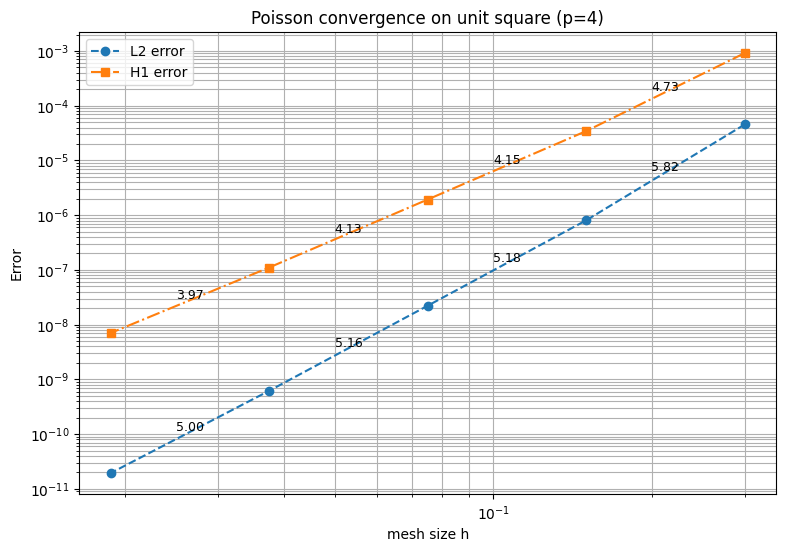

In [8]:
# Choose refinement ladder
hs = [0.3 / (2**i) for i in range(5)]
order = 4  # try 1,2,3...

study = run_study(
    solve_fn=poisson_solve,
    hs=hs,
    orders=order,
    params_list=[{}],          # no extra parameters for Poisson
    errors = {"L2": poisson_err_L2, "H1": poisson_err_H1},
    store_solution=True,       # set False if you only want error numbers
)

grp = study.group(order=order, params={})

plot_group(grp, title=f"Poisson convergence on unit square (p={order})")

In [9]:
# pick one of the hs you used above
h_pick = hs[-1]
rr = grp[h_pick]
draw_run(rr, name=f"u_h (h={h_pick:g}, p={order})")



WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

# Advection Diffusion


## Standard Galerkin

In [ ]:
from ngsolve.meshes import Make1DMesh
from math import pi


def uex_duex_eps(eps: float):
    k = 11 * pi
    denom = 1 + (eps * k) ** 2

    A = eps / denom
    B = -1 / (k * denom)

    q = exp(-1 / eps)
    inv_em1 = q / (1 - q)

    C2 = -(2 / (k * denom)) * inv_em1
    C1 = 1 / (k * denom) - C2

    u = C1 + C2 * exp(x / eps) + A * sin(k * x) + B * cos(k * x)
    du = (C2 / eps) * exp(x / eps) + A * k * cos(k * x) - B * k * sin(k * x)

    return CF(u), CF(du)


def err_L2_advecdiff(gfu, mesh, extra):
    uex = extra["uex"]
    return float(np.sqrt(Integrate((gfu - uex) ** 2, mesh)))


def err_H1_advecdiff(gfu, mesh, extra):
    duex = extra["duex"]
    return float(np.sqrt(Integrate((grad(gfu)[0] - duex) ** 2, mesh)))


def get_solver(eps: float, beta: float = 1.0):
    uex, duex = uex_duex_eps(eps)

    def solve(*, h: float, order: int, **params):
        mesh = Make1DMesh(int(round(1 / h)))
        f = CF(sin(11 * pi * x))
        V = H1(mesh, order=order, dirichlet=".*")
        u, v = V.TnT()

        a = BilinearForm(V, symmetric=False)
        a += eps * InnerProduct(grad(u), grad(v)) * dx
        a += beta * grad(u)[0] * v * dx

        L = LinearForm(V)
        L += f * v * dx

        gfu = GridFunction(V)
        with TaskManager():
            a.Assemble()
            L.Assemble()
            gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs()) * L.vec

        extra = {"dofs": V.ndof, "eps": eps, "beta": beta, "uex": uex, "duex": duex}
        return gfu, mesh, extra

    return solve


def get_modified_solver(eps: float, beta: float = 1.0):
    uex, duex = uex_duex_eps(eps)

    def solve(*, h: float, order: int, **params):
        N = max(2, int(round(1 / h)))
        mesh = Make1DMesh(N)
        f = CF(sin(11 * pi * x))
        V = H1(mesh, order=order, dirichlet=".*")
        u, v = V.TnT()

        eps_h = eps + abs(beta) * h / 2

        a = BilinearForm(V, symmetric=False)
        a += eps_h * InnerProduct(grad(u), grad(v)) * dx
        a += beta * grad(u)[0] * v * dx

        L = LinearForm(V)
        L += f * v * dx

        gfu = GridFunction(V)
        with TaskManager():
            a.Assemble()
            L.Assemble()
            gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs()) * L.vec

        extra = {"dofs": V.ndof, "eps": eps, "beta": beta, "eps_h": eps_h, "uex": uex, "duex": duex}
        return gfu, mesh, extra

    return solve

## Run studies (standard vs modified) for many eps and plot

In [ ]:
eps_list = [10.0 ** (-k) for k in range(0, 13)]     # 1e0 ... 1e-12
hs = [0.2 / (2 ** i) for i in range(9)]             # 0.2 ... 0.000390625
order = 4

errors = {"L2": err_L2_advecdiff, "H1": err_H1_advecdiff}

all_std: Dict[float, ConvergenceStudy] = {}
all_mod: Dict[float, ConvergenceStudy] = {}

for eps in eps_list:
    std = run_study(
        solve_fn=get_solver(eps, beta=1.0),
        hs=hs,
        orders=order,
        params_list=[{}],
        errors=errors,
        store_solution=True,
    )
    mod = run_study(
        solve_fn=get_modified_solver(eps, beta=1.0),
        hs=hs,
        orders=order,
        params_list=[{}],
        errors=errors,
        store_solution=True,
    )

    all_std[eps] = std
    all_mod[eps] = mod

    grp_std = std.group(order=order, params={})
    grp_mod = mod.group(order=order, params={})

    print(f"\n=== eps={eps:g} | standard ===")
    print(table_group(grp_std))
    plot_group(grp_std, title=f"Standard Galerkin (eps={eps:g}, p={order})")

    print(f"\n=== eps={eps:g} | modified ===")
    print(table_group(grp_mod))
    plot_group(grp_mod, title=f"Modified (eps={eps:g}, p={order})")

## Compare methods on one plot for fixed eps

In [ ]:
eps = 1e-4
plot_compare(
    {"standard": all_std[eps], "modified": all_mod[eps]},
    order=order,
    params={},
    error_name="L2",
    title=f"Compare methods (eps={eps:g}, p={order}) — L2",
    annotate=False,
)

plot_compare(
    {"standard": all_std[eps], "modified": all_mod[eps]},
    order=order,
    params={},
    error_name="H1",
    title=f"Compare methods (eps={eps:g}, p={order}) — H1",
    annotate=False,
)

## Draw a stored solution

In [ ]:
eps = 1e-4
grp = all_mod[eps].group(order=order, params={})
h_pick = hs[-1]
rr = grp[h_pick]
draw_run(rr, name=f"u_h (modified, eps={eps:g}, h={h_pick:g}, p={order})")

## Least Squares

In [47]:
from ngsolve import *
from ngsolve.meshes import Make1DMesh
from ngsolve import specialcf
from math import pi

def get_gls_solver(eps: float, beta: float = 1.0):
    uex, duex = uex_duex_eps(eps)

    def solve(*, h: float, order: int, **params):
        N = max(2, int(round(1/h)))
        mesh = Make1DMesh(N)

        f = CF(sin(11*pi*x))
        V = H1(mesh, order=order, dirichlet=".*")
        u, v = V.TnT()

        # elementwise derivatives (OK for H1 polynomials)
        ux  = u.Diff(x)
        vx  = v.Diff(x)
        uxx = ux.Diff(x)
        vxx = vx.Diff(x)

        # strong operator L(.) = -eps u'' + beta u'
        Lu = -eps*uxx + beta*ux
        Lv = -eps*vxx + beta*vx

        # elementwise tau_K (use mesh_size, not a scalar)
        hK  = specialcf.mesh_size
        Pe  = abs(beta)*hK/(2*eps + 1e-30)
        cothPe = cosh(Pe)/(sinh(Pe) + 1e-30)
        tau = (hK/(2*abs(beta) + 1e-30)) * (cothPe - 1/(Pe + 1e-30))

        a = BilinearForm(V, symmetric=False)
        # standard weak form
        a += eps * ux * vx * dx
        a += beta * ux * v  * dx
        # GLS term (this is the “least squares” part)
        a += tau * Lu * Lv * dx

        L = LinearForm(V)
        L += f * v * dx
        # consistent GLS rhs
        L += tau * f * Lv * dx

        gfu = GridFunction(V)
        with TaskManager():
            a.Assemble()
            L.Assemble()
            gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs()) * L.vec

        extra = {
            "dofs": V.ndof,
            "eps": float(eps),
            "beta": float(beta),
            "uex": uex,
            "duex": duex,
            # store tau expression for reuse in error norm (optional)
            "tau": tau,
        }
        return gfu, mesh, extra

    return solve

In [48]:
import numpy as np
from ngsolve import Integrate

def err_GLS_norm_advecdiff(gfu, mesh, extra):
    eps  = float(extra["eps"])
    beta = float(extra["beta"])
    uex  = extra["uex"]

    # derivatives
    uh_x  = gfu.Diff(x)
    uh_xx = uh_x.Diff(x)

    uex_x  = uex.Diff(x)
    uex_xx = uex_x.Diff(x)

    v   = gfu - uex
    vx  = uh_x  - uex_x
    vxx = uh_xx - uex_xx

    # use SAME tau as solver (elementwise)
    tau = extra.get("tau", specialcf.mesh_size/(2*abs(beta) + 1e-30))

    Lv = -eps*vxx + beta*vx

    val = Integrate(v*v + eps*vx*vx + tau*Lv*Lv, mesh)
    return float(np.sqrt(val))


=== eps=1 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	1.99758e+10	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	6.57360e+09	   1.603
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	7.69529e+09	  -0.227
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	4.65399e+09	   0.726
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	2.44003e+09	   0.932
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	1.23480e+09	   0.983
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	6.19283e+08	   0.996
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	3.09878e+08	   0.999
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	1.54969e+08	   1.000


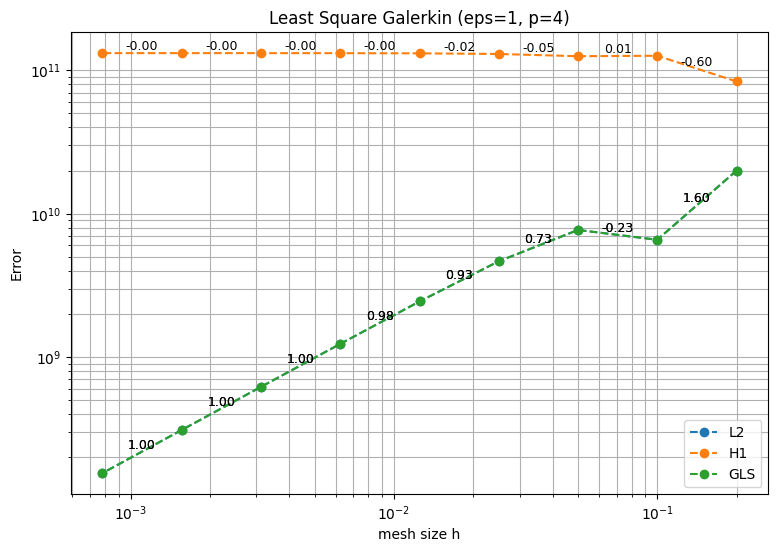


=== eps=0.1 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	1.99758e+10	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	6.57360e+09	   1.603
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	7.69529e+09	  -0.227
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	4.65399e+09	   0.726
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	2.44003e+09	   0.932
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	1.23480e+09	   0.983
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	6.19283e+08	   0.996
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	3.09878e+08	   0.999
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	1.54969e+08	   1.000


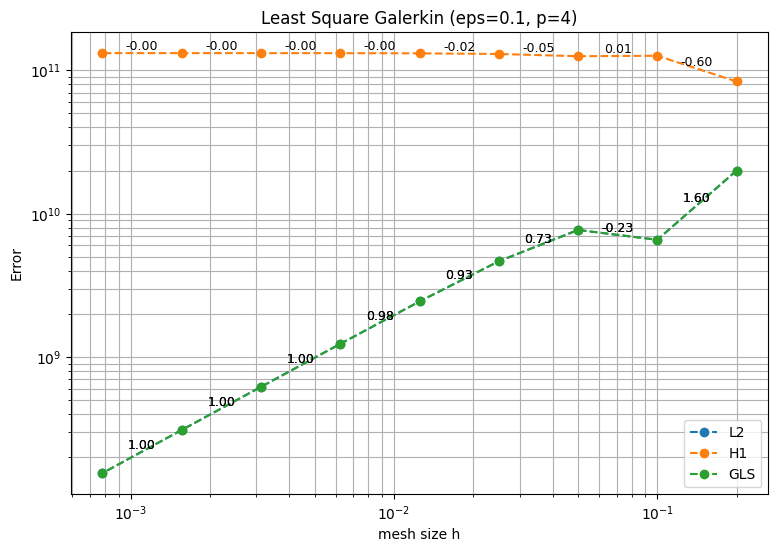


=== eps=0.01 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	1.99758e+10	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	6.57360e+09	   1.603
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	7.69529e+09	  -0.227
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	4.65399e+09	   0.726
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	2.44003e+09	   0.932
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	1.23480e+09	   0.983
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	6.19283e+08	   0.996
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	3.09878e+08	   0.999
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	1.54969e+08	   1.000


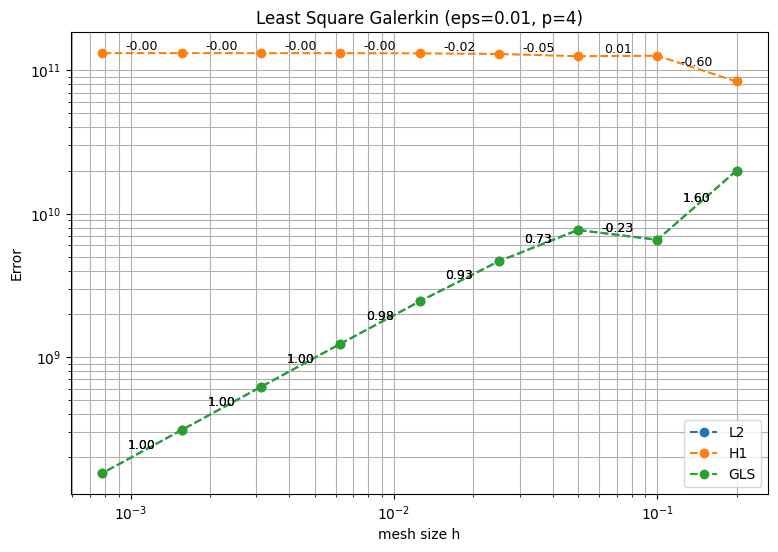


=== eps=0.001 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	1.99758e+10	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	6.57360e+09	   1.603
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	7.69529e+09	  -0.227
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	4.65399e+09	   0.726
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	2.44003e+09	   0.932
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	1.23480e+09	   0.983
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	6.19283e+08	   0.996
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	3.09878e+08	   0.999
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	1.54969e+08	   1.000


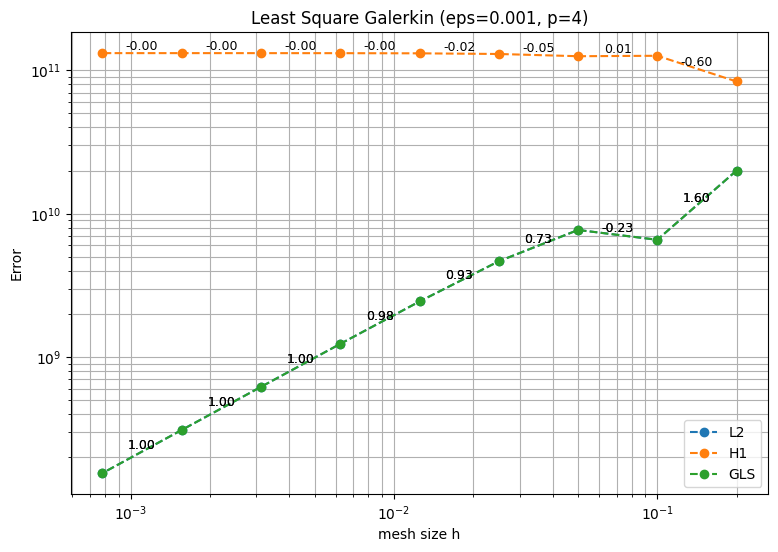


=== eps=0.0001 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	6.57360e+09	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	7.69529e+09	  -0.227
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	4.65399e+09	   0.726
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	2.44003e+09	   0.932
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	1.23480e+09	   0.983
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	6.19283e+08	   0.996
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	3.09878e+08	   0.999
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	1.54969e+08	   1.000


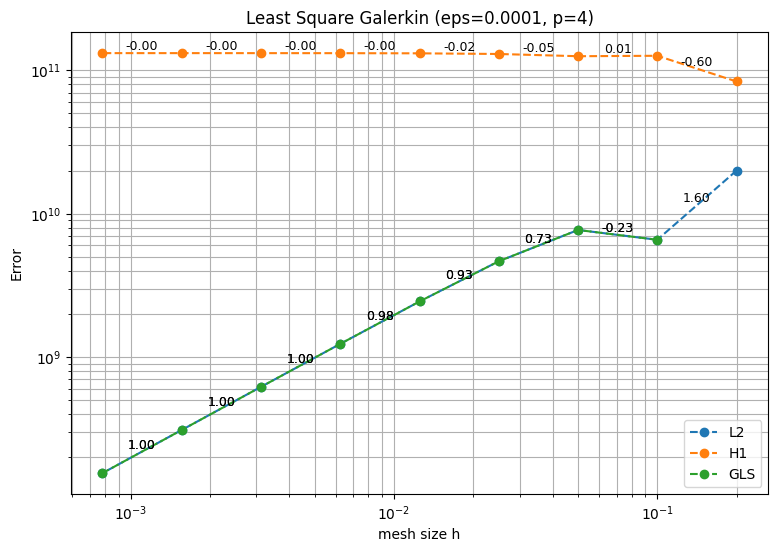


=== eps=1e-05 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	2.44003e+09	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	1.23480e+09	   0.983
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	6.19283e+08	   0.996
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	3.09878e+08	   0.999
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	1.54969e+08	   1.000


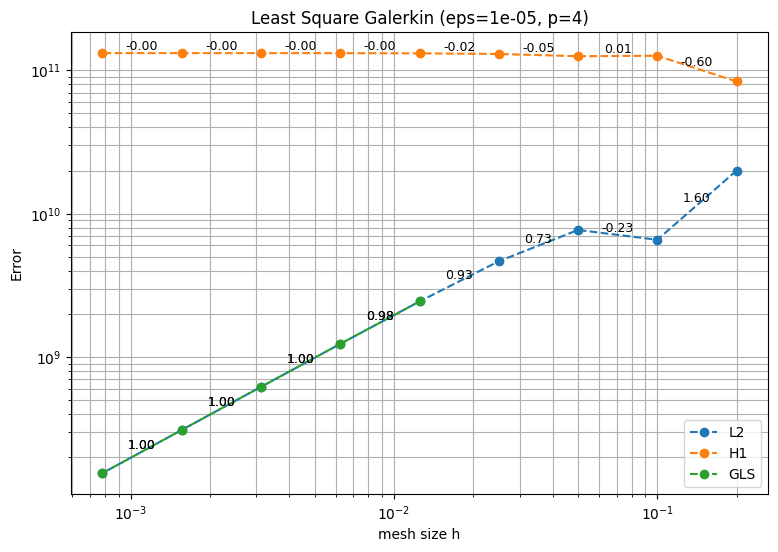


=== eps=1e-06 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	nan	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	nan	     nan
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	nan	     nan
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	nan	     nan
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	1.54969e+08	     nan


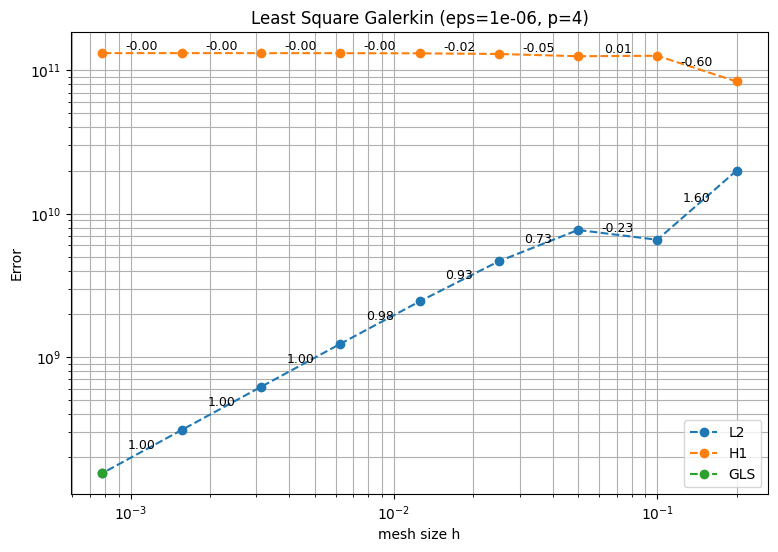


=== eps=1e-07 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	nan	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	nan	     nan
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	nan	     nan
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	nan	     nan
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	nan	     nan


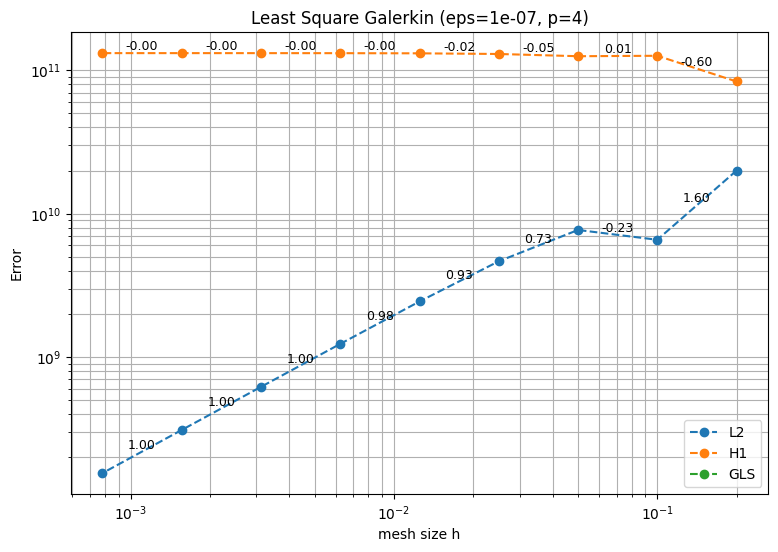


=== eps=1e-08 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	nan	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	nan	     nan
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	nan	     nan
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	nan	     nan
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	nan	     nan


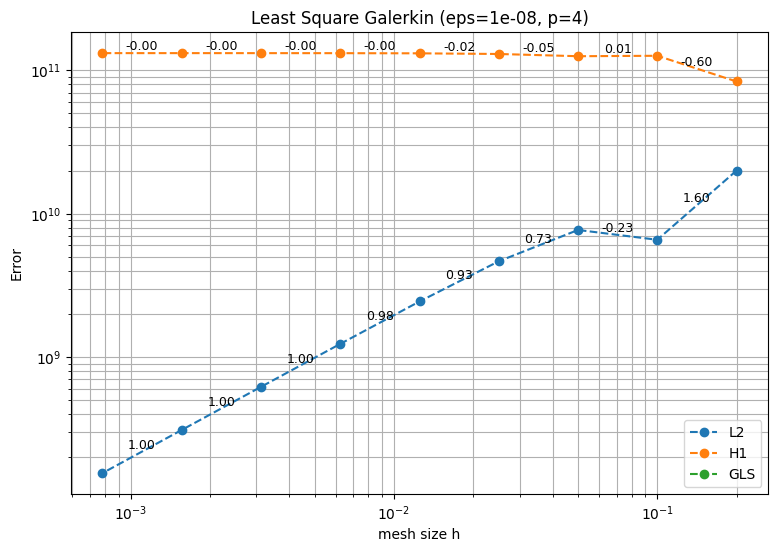


=== eps=1e-09 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	nan	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	nan	     nan
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	nan	     nan
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	nan	     nan
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	nan	     nan


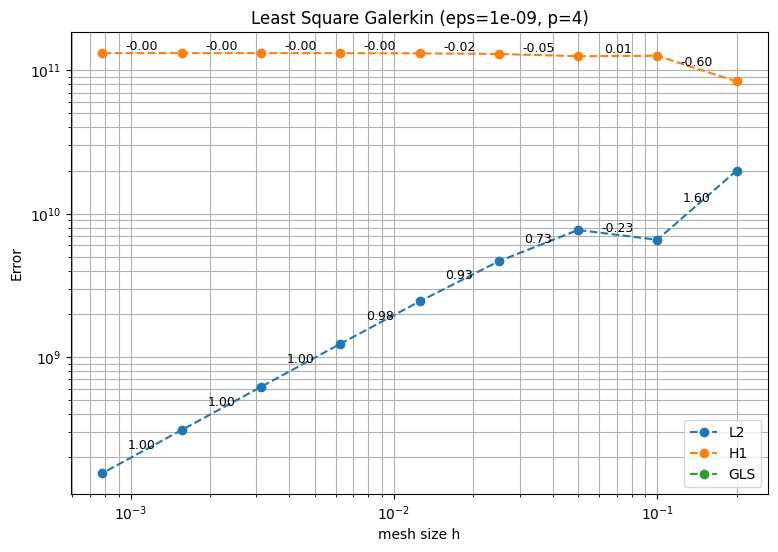


=== eps=1e-10 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	nan	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	nan	     nan
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	nan	     nan
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	nan	     nan
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	nan	     nan


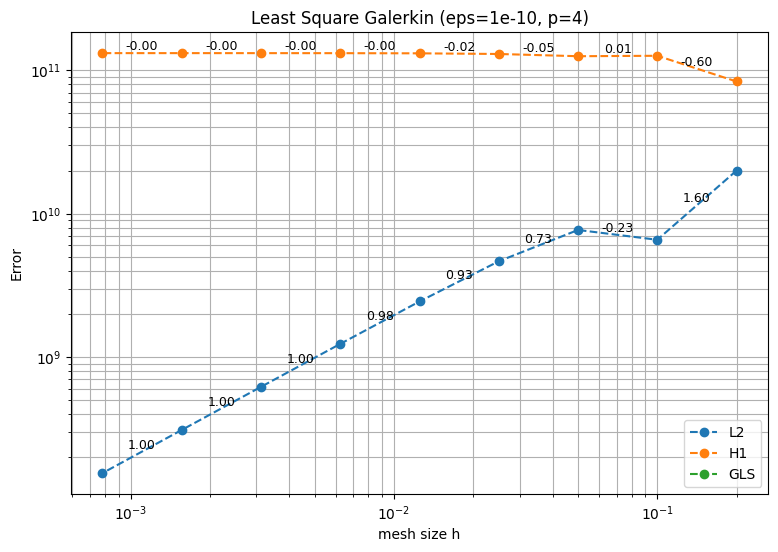


=== eps=1e-11 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	nan	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	nan	     nan
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	nan	     nan
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	nan	     nan
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	nan	     nan


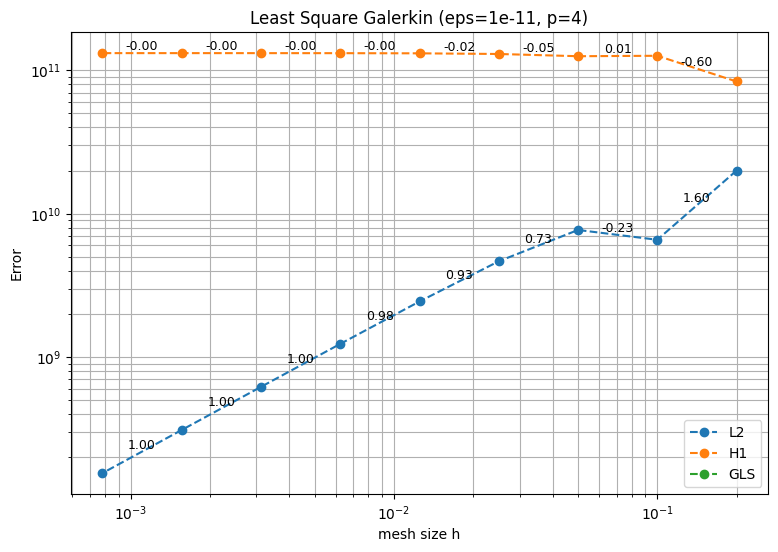


=== eps=1e-12 | gls ===
order=4
h		L2 err	L2 rate		H1 err	H1 rate		GLS err	GLS rate
----------------------------------------------------------------------------------------
2.00000e-01	1.99758e+10	        	8.35371e+10	        	nan	        
1.00000e-01	6.57360e+09	   1.603	1.26259e+11	  -0.596	nan	     nan
5.00000e-02	7.69529e+09	  -0.227	1.25375e+11	   0.010	nan	     nan
2.50000e-02	4.65399e+09	   0.726	1.29955e+11	  -0.052	nan	     nan
1.25000e-02	2.44003e+09	   0.932	1.31326e+11	  -0.015	nan	     nan
6.25000e-03	1.23480e+09	   0.983	1.31656e+11	  -0.004	nan	     nan
3.12500e-03	6.19283e+08	   0.996	1.31736e+11	  -0.001	nan	     nan
1.56250e-03	3.09878e+08	   0.999	1.31755e+11	  -0.000	nan	     nan
7.81250e-04	1.54969e+08	   1.000	1.31760e+11	  -0.000	nan	     nan


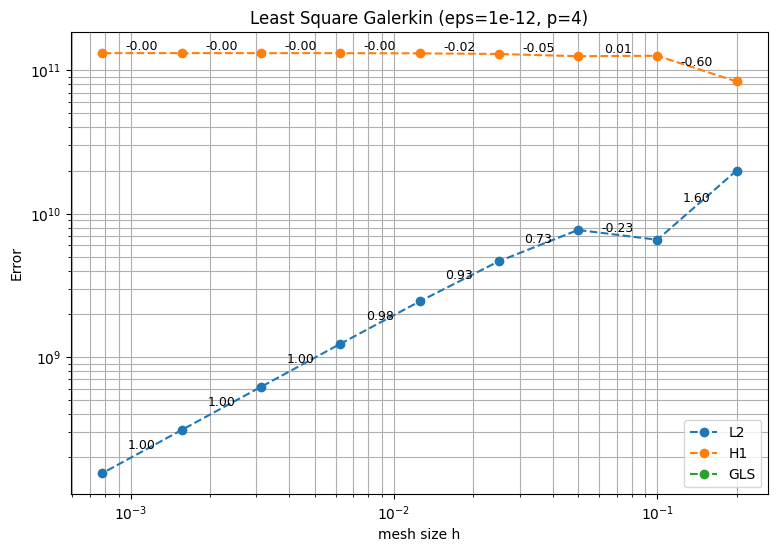

In [49]:

import numpy as np
gls_errors = {"L2": err_L2_advecdiff, "H1": err_H1_advecdiff, "GLS": err_GLS_norm_advecdiff}
for eps in eps_list:
    std = run_study(
        solve_fn=get_gls_solver(eps, beta=1.0),
        hs=hs,
        orders=order,
        params_list=[{}],
        errors=gls_errors,
        store_solution=True,
    )
    grp = std.group(order=order, params={})
    print(f"\n=== eps={eps:g} | gls ===")
    print(table_group(grp))
    plot_group(grp, title=f"Least Square Galerkin (eps={eps:g}, p={order})")